In [112]:
import numpy as np
from scipy.stats import qmc
import cProfile
import matplotlib.pyplot as plt

class LSMOptionPricer:
    def __init__(self, S0, K, T, r, sigma, N, M, k, option_type, dividend=0):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.N = N
        self.M = M
        self.k = k
        self.delta = dividend
        self.option_type = option_type
        self.rng = np.random.default_rng()


    def Basis_Function(self, X):
        if self.k == 1:
            A = np.column_stack([np.ones_like(X), 1 - X])
        elif self.k == 2:
            A = np.column_stack([np.ones_like(X), 1 - X, 1/2 * (2 - 4 * X + X**2)])
        elif self.k == 3:
            A = np.column_stack([np.ones_like(X), 1 - X, 1/2 * (2 - 4 * X + X**2),
                                 1/6 * (6 - 18 * X + 9 * X**2 - X**3)])
        elif self.k == 4:
            A = np.column_stack([np.ones_like(X), 1 - X, 1/2 * (2 - 4 * X + X**2),
                                 1/6 * (6 - 18 * X + 9 * X**2 - X**3),
                                 1/24 * (24 - 96 * X + 72 * X**2 - 16 * X**3 + X**4)])
        elif self.k == 5:
            A = np.column_stack([np.ones_like(X), 1 - X, 1/2 * (2 - 4 * X + X**2),
                                 1/6 * (6 - 18 * X + 9 * X**2 - X**3),
                                 1/24 * (24 - 96 * X + 72 * X**2 - 16 * X**3 + X**4),
                                 1/120 * (120 - 600 * X + 600 * X**2 - 200 * X**3 + 25 * X**4 - X**5)])
        else:
            raise ValueError('Too many basis functions requested')

        return A
    
    def MC_Stock_Path(self):
        dt = self.T/self.N
        t = np.linspace(0, self.T, self.N + 1)
        z = np.random.randn(self.N, self.M//2) 
        z = np.concatenate((z, -z), axis=1)
        S = np.zeros((self.N+1, self.M))
        S[0,:] = S0
        for i in range(1,self.N+1):
            S[i,:] = S[i-1,:] * np.exp((self.r - self.delta - 0.5 * self.sigma**2) * dt + self.sigma * np.sqrt(dt) * z[i-1,:])
        return S
    
    def Standard(self,boundary = False):
        if self.option_type != 'call' and self.option_type != 'put':
            raise ValueError("Error: Enter 'call' or 'put'")
        SP = self.MC_Stock_Path()
        dt = self.T / self.N
        t = np.arange(0, self.T + dt, dt)
        P = np.maximum(self.K - SP[-1,:], 0) if self.option_type == 'put' else np.maximum(self.K - SP[-1,:], 0)
        R = []
        for i in range(self.N - 1, 0, -1):
            S = SP[i,:]
            itm = np.where(S < self.K)[0] if self.option_type == 'put' else np.where(S > self.K)[0]
            X = S[itm]
            A = self.Basis_Function(X)
            Y = np.exp(-self.r * dt) * P[itm]
            beta = np.linalg.lstsq(A, Y, rcond=None)[0]
            C = np.dot(A, beta)
            E = self.K - X if self.option_type == 'put' else X - self.K
            itm_ex = itm[C < E]
            if boundary and len(itm_ex) !=0:
                R.append([i,max(S[itm_ex])])
            no_ex = np.setdiff1d(np.arange(0, self.M), itm_ex)
            P[itm_ex] = E[C < E]
            P[no_ex] = P[no_ex] * np.exp(-self.r * dt)
        if boundary:
            self.boundary(R)
        option_price = np.mean(np.exp(-self.r * dt) * P)
        return option_price



    def Brownian_Bridge(self,boundary = False):
        if self.option_type != 'call' and self.option_type != 'put':
            raise ValueError("Error: Enter 'call' or 'put'")
        dt = self.T / self.N
        t = np.linspace(0, self.T, self.N + 1)
        z = self.rng.normal(size=(self.M // 2,))
        z = np.concatenate((z, -z))
        B = (self.r - self.delta - 0.5 * self.sigma**2) * T + self.sigma * z
        S = S0 * np.exp(B)
        P = np.maximum(self.K - S, 0) if self.option_type == 'put' else np.maximum(S - self.K, 0)
        R = []
        for i in range(self.N - 1, 0, -1):
            z = self.rng.normal(size=(self.M // 2,))
            z = np.concatenate((z, -z))
            B = B * t[i] / t[i+1] + self.sigma * np.sqrt(dt * t[i]/t[i+1])*z
            S = self.S0 * np.exp(B)
            itm = np.flatnonzero(S < self.K) if self.option_type == 'put' else np.flatnonzero(S > self.K)
            X = S[itm]
            A = self.Basis_Function(X)
            Y = np.exp(-self.r * dt) * P[itm]
            #beta = np.linalg.lstsq(A, Y, rcond=None)[0]
            beta = self.least_squares_qr(A,Y)
            C = np.dot(A, beta)
            E = self.K - X if self.option_type == 'put' else X - self.K
            itm_ex = itm[C < E]
            
            if boundary and len(itm_ex) !=0:
                R.append([i,max(S[itm_ex])]) if self.option_type == 'put' else R.append([i,min(S[itm_ex])])
            no_ex = np.setdiff1d(np.arange(0, self.M), itm_ex)
            P[itm_ex] = E[C < E]
            P[no_ex] = P[no_ex] * np.exp(-self.r * dt)
        if boundary:
            self.boundary(R)
        option_price = np.mean(np.exp(-self.r * dt) * P)
        return option_price


    
    def boundary(self,R):
        X, Y = zip(*R)
        plt.plot(X, Y)
        plt.xlabel('Steps')
        plt.ylabel('Stock Price')
        plt.title('Boundary Plot')
        plt.show()


    def least_squares_qr(self, A, b):
        Q, R = np.linalg.qr(A, mode='reduced')
        x = np.linalg.lstsq(R, Q.T @ b, rcond=1)[0]
        return x
    
    def Brownian_Bridge_CI(self,boundary = False,confidence_level=0.95):
        if self.option_type != 'call' and self.option_type != 'put':
            raise ValueError("Error: Enter 'call' or 'put'")
        dt = self.T / self.N
        t = np.linspace(0, self.T, self.N + 1)
        z = np.random.randn(self.M//2) 
        z = np.concatenate((z, -z))
        B = (self.r - self.delta - 0.5 * self.sigma**2) * T + self.sigma * z
        S = S0 * np.exp(B)
        P = np.maximum(self.K - S, 0) if self.option_type == 'put' else np.maximum(S - self.K, 0)
        for i in range(self.N - 1, 0, -1):
            z = np.random.randn(self.M//2) 
            z = np.concatenate((z, -z))
            B = B * t[i] / t[i+1] + self.sigma * np.sqrt(dt * t[i]/t[i+1])*z
            S = self.S0 * np.exp(B)
            itm = np.flatnonzero(S < self.K) if self.option_type == 'put' else np.flatnonzero(S > self.K)
            X = S[itm]
            A = self.Basis_Function(X)
            Y = np.exp(-self.r * dt) * P[itm]
            #beta = np.linalg.lstsq(A, Y, rcond=None)[0]
            beta = self.least_squares_qr(A,Y)
            C = np.dot(A, beta)
            E = self.K - X if self.option_type == 'put' else X - self.K
            itm_ex = itm[C < E]
            no_ex = np.setdiff1d(np.arange(0, self.M), itm_ex)
            P[itm_ex] = E[C < E]
            P[no_ex] = P[no_ex] * np.exp(-self.r * dt)
        option_price =np.exp(-self.r * dt) * P
        mean_option_price = np.mean(option_price)
        std_dev_option_price = np.std(option_price, ddof=1)  

        z_score = norm.ppf((1 + confidence_level) / 2)
        margin_of_error = z_score * (std_dev_option_price / np.sqrt(self.M))
        lower_bound = mean_option_price - margin_of_error
        upper_bound = mean_option_price + margin_of_error

        return mean_option_price, (lower_bound, upper_bound)


    def Brownian_Bridge_Put(self):
        dt = self.T / self.N
        t = np.linspace(0, self.T, self.N + 1)
        z = np.random.randn(self.M//2) 
        z = np.concatenate((z, -z))
        B = (self.r - self.delta - 0.5 * self.sigma**2) * T + self.sigma * z
        S = S0 * np.exp(B)
        P = np.maximum(self.K - S, 0)
        R = []
        for i in range(self.N - 1, 0, -1):
            z = np.random.randn(self.M//2) 
            z = np.concatenate((z, -z))
            B = B * t[i] / t[i+1] + self.sigma * np.sqrt(dt * t[i]/t[i+1])*z
            S = self.S0 * np.exp(B)
            itm = np.flatnonzero(S < self.K)
            X = S[itm]
            A = self.Basis_Function(X)
            Y = np.exp(-self.r * dt) * P[itm]
            #beta = np.linalg.lstsq(A, Y, rcond=None)[0]
            beta = self.least_squares_qr(A,Y)
            C = np.dot(A, beta)
            E = self.K - X
            itm_ex = itm[C < E]
            no_ex = np.setdiff1d(np.arange(0, self.M), itm_ex)
            P[itm_ex] = E[C < E]
            P[no_ex] = P[no_ex] * np.exp(-self.r * dt)
            if len(itm_ex) !=0:
                R.append([i,max(S[itm_ex])])
        option_price = np.mean(np.exp(-self.r * dt) * P)
        return R
    def Brownian_Bridge_Call(self):
        dt = self.T / self.N
        t = np.linspace(0, self.T, self.N + 1)
        z = np.random.randn(self.M//2) 
        z = np.concatenate((z, -z))
        B = (self.r - self.delta - 0.5 * self.sigma**2) * T + self.sigma * z
        S = S0 * np.exp(B)
        P = np.maximum(S - self.K, 0)
        R = []
        for i in range(self.N - 1, 0, -1):
            z = np.random.randn(self.M//2) 
            z = np.concatenate((z, -z))
            B = B * t[i] / t[i+1] + self.sigma * np.sqrt(dt * t[i]/t[i+1])*z
            S = self.S0 * np.exp(B)
            itm = np.flatnonzero(S > self.K)
            X = S[itm]
            A = self.Basis_Function(X)
            Y = np.exp(-self.r * dt) * P[itm]
            #beta = np.linalg.lstsq(A, Y, rcond=None)[0]
            beta = self.least_squares_qr(A,Y)
            C = np.dot(A, beta)
            E = X - self.K
            itm_ex = itm[C < E]
            no_ex = np.setdiff1d(np.arange(0, self.M), itm_ex)
            P[itm_ex] = E[C < E]
            P[no_ex] = P[no_ex] * np.exp(-self.r * dt)
            if len(itm_ex) !=0:
                R.append([i,max(S[itm_ex])])
        option_price = np.mean(np.exp(-self.r * dt) * P)
        return R

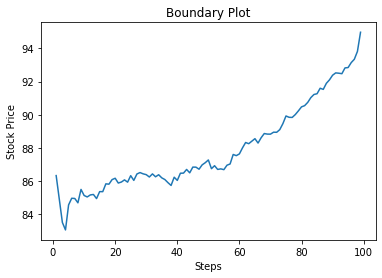

10.712639725241976

In [10]:
S0 = 90
K = 100
T = 1
r = 0.03
sigma = 0.15
N = 100
M = 100000
k = 4
dividend = 0
put_Pricer = LSMOptionPricer(S0, K, T, r, sigma, N, M, k, option_type='put',dividend=0)
put_Pricer.Brownian_Bridge(boundary=True)

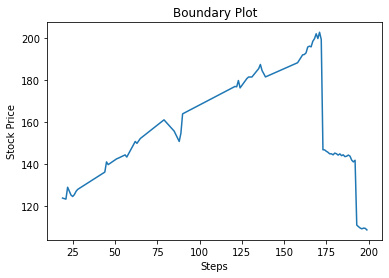

7.467677542119845

In [86]:
S0 = 100
K = 100
T = 1
r = 0.03
sigma = 0.15
N = 200
M = 10**6
k = 5
call_Pricer = LSMOptionPricer(S0, K, T, r, sigma, N, M, k, option_type='call',dividend=0)
call_Pricer.Brownian_Bridge(boundary=True)

In [129]:
import time

start_time = time.time()

S0 = 100
K = 100
T = 1
r = 0.03
sigma = 0.15
N = 200
M = 10**6
k = 5
dividend = 0
put_Pricer = LSMOptionPricer(S0, K, T, r, sigma, N, M, k, option_type='put',dividend=0)
print(put_Pricer.Brownian_Bridge())

end_time = time.time()

elapsed_time = end_time - start_time

print(f"Time taken: {elapsed_time} seconds")




4.820048374294719
Time taken: 77.97367405891418 seconds


In [131]:
from tabulate import tabulate
data = [
    ['Brownian Bridge', 77.97367405891418],
    ['Standard', 93.05370926856995]
]

headers = ["", "time for S=100 in sec"]

table = tabulate(data, headers, tablefmt="pretty")
print(table)

+-----------------+-----------------------+
|                 | time for S=100 in sec |
+-----------------+-----------------------+
| Brownian Bridge |   77.97367405891418   |
|    Standard     |   93.05370926856995   |
+-----------------+-----------------------+


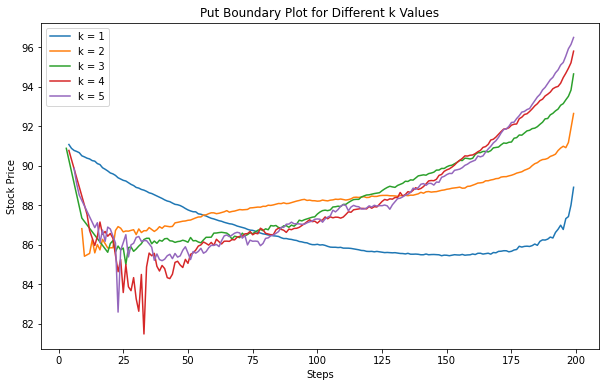

<Figure size 432x288 with 0 Axes>

In [70]:
import matplotlib.pyplot as plt

S0 = 100
K = 100
T = 1
r = 0.03
sigma = 0.15
N = 200
M = 10**6
k_max = 5  

plt.figure(figsize=(10, 6))  
for k in range(1, k_max + 1):
    R = LSMOptionPricer(S0, K, T, r, sigma, N, M, k, option_type='put', dividend=0).Brownian_Bridge_Put()
    X, Y = zip(*R)
    plt.plot(X, Y, label=f'k = {k}')

plt.xlabel('Steps')
plt.ylabel('Stock Price')
plt.title('Put Boundary Plot for Different k Values')

plt.legend()

plt.show()

plt.savefig('Put Boundary Plot for Different k Values.png')



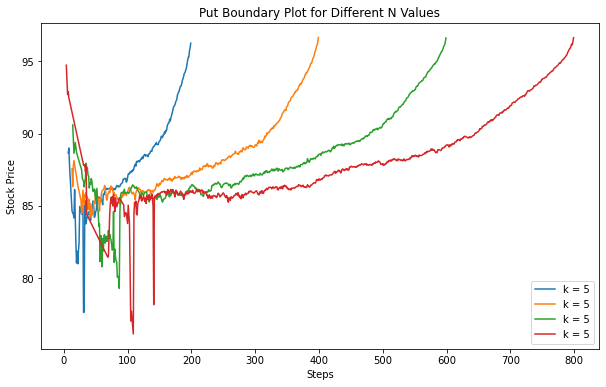

<Figure size 432x288 with 0 Axes>

In [75]:
import matplotlib.pyplot as plt

S0 = 100
K = 100
T = 1
r = 0.03
sigma = 0.15
M = 10**6
k = 5  

plt.figure(figsize=(10, 6))  
for N in range(200,1000,200):
    R = LSMOptionPricer(S0, K, T, r, sigma, N, M, k, option_type='put', dividend=0).Brownian_Bridge_Put()
    X, Y = zip(*R)
    plt.plot(X, Y, label=f'N = {N}')

plt.xlabel('Steps')
plt.ylabel('Stock Price')
plt.title('Put Boundary Plot for Different N Values')
plt.legend()
plt.show()
plt.savefig('Put Boundary Plot for Different N Values.png')


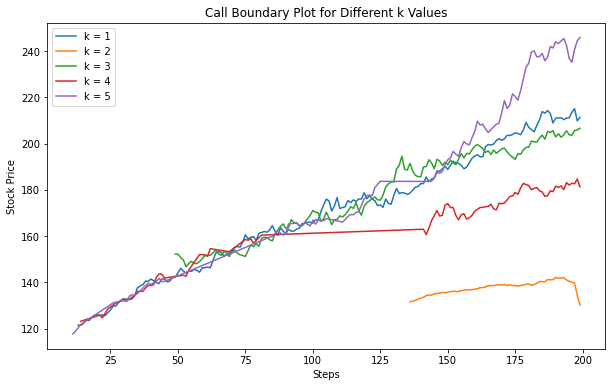

<Figure size 432x288 with 0 Axes>

In [82]:
S0 = 100
K = 100
T = 1
r = 0.03
sigma = 0.15
N = 200
M = 10**6
k_max = 5 

plt.figure(figsize=(10, 6))  

for k in range(1, k_max + 1):
    R = LSMOptionPricer(S0, K, T, r, sigma, N, M, k, option_type='call', dividend=0).Brownian_Bridge_Call()
    X, Y = zip(*R)
    plt.plot(X, Y, label=f'k = {k}')

plt.xlabel('Steps')
plt.ylabel('Stock Price')
plt.title('Call Boundary Plot for Different k Values')

plt.legend()

plt.show()

plt.savefig('Call Boundary Plot for Different k Values.png')


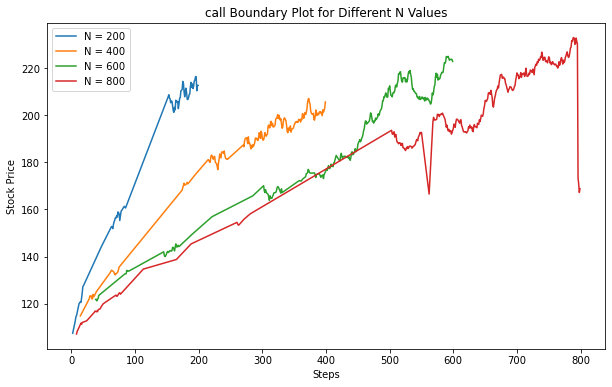

<Figure size 432x288 with 0 Axes>

In [87]:
S0 = 100
K = 100
T = 1
r = 0.03
sigma = 0.15
M = 10**6
k = 5  

plt.figure(figsize=(10, 6))  
for N in range(200,1000,200):
    R = LSMOptionPricer(S0, K, T, r, sigma, N, M, k, option_type='call', dividend=0).Brownian_Bridge_Call()
    X, Y = zip(*R)
    plt.plot(X, Y, label=f'N = {N}')

plt.xlabel('Steps')
plt.ylabel('Stock Price')
plt.title('call Boundary Plot for Different N Values')
plt.legend()
plt.show()
plt.savefig('call Boundary Plot for Different N Values.png')

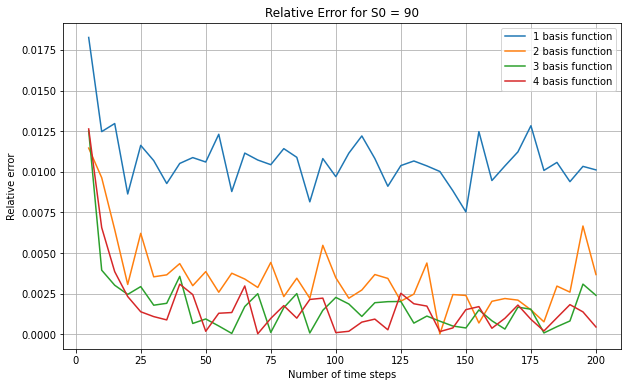

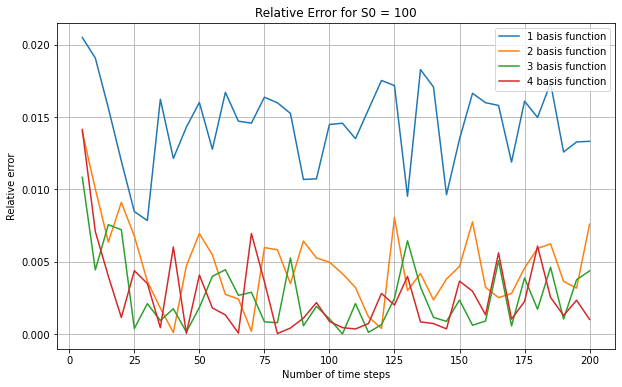

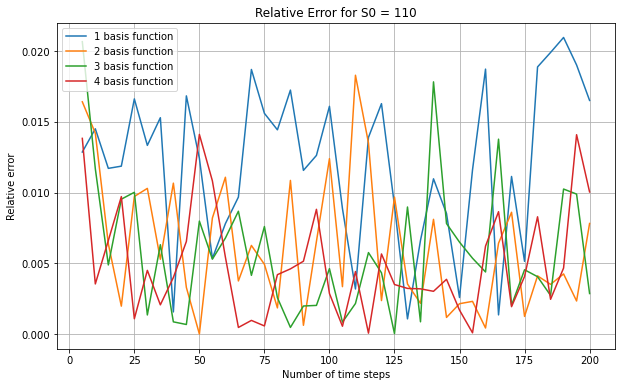

In [62]:
S_values = [90, 100, 110]
N_min = 5
N_max = 200
N_step = 5
k_max = 4
M = 10**5
true = [10.726486710094511,4.820608184813253,1.828207584020458]
i=0
for S0 in S_values:
    RE = np.zeros((40, k_max))

    for k in range(1, k_max + 1):
        for N in range(N_min, N_max + 1, N_step):
            y = (N - N_min) // N_step
            approx = LSMOptionPricer(S0, K, T, r, sigma, N, M, k, option_type='put', dividend=0).Brownian_Bridge()
            RE[y, k - 1] = abs((true[i] - approx) / true[i])
    i += 1 
    x = range(N_min, N_max + 1, N_step)

    plt.figure(figsize=(10, 6))
    plt.plot(x, RE[:, 0], label='1 basis function')
    plt.plot(x, RE[:, 1], label='2 basis function')
    plt.plot(x, RE[:, 2], label='3 basis function')
    plt.plot(x, RE[:, 3], label='4 basis function')
    plt.xlabel('Number of time steps')
    plt.ylabel('Relative error')
    plt.title(f'Relative Error for S0 = {S0}')
    plt.grid(True)
    plt.legend()

    plt.savefig(f'relative_error_plot_S{S0}.png')

    plt.show()


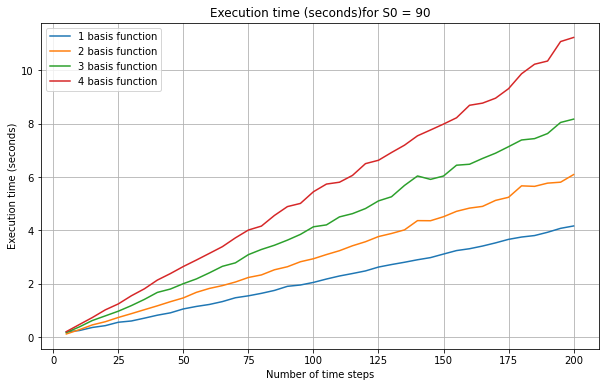

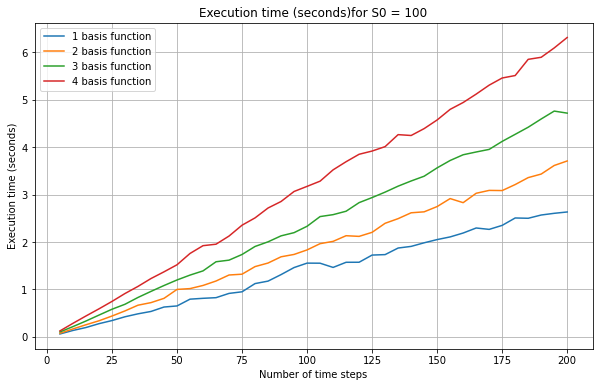

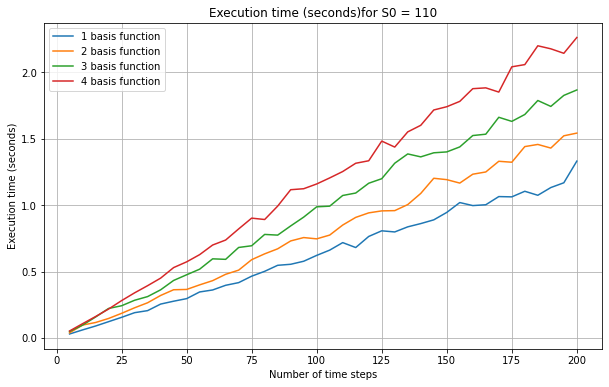

In [67]:
import time 
S_values = [90, 100, 110]
N_min = 5
N_max = 200
N_step = 5
k_max = 4
M = 10**5
i = 0 
for S0 in S_values:
    ES = np.zeros((40, k_max))
    for k in range(1, k_max + 1):
        for N in range(N_min, N_max + 1, N_step):
            S=time.time()
            y = (N - N_min) // N_step
            approx = LSMOptionPricer(S0, K, T, r, sigma, N, M, k, option_type='put', dividend=0).Brownian_Bridge()
            E=time.time()
            ES[y, k - 1] = E-S
    i += 1        

    x = range(N_min, N_max + 1, N_step)

    plt.figure(figsize=(10, 6))
    plt.plot(x, ES[:,0], label='1 basis function')
    plt.plot(x, ES[:,1], label='2 basis function')
    plt.plot(x, ES[:,2], label='3 basis function')
    plt.plot(x, ES[:,3], label='4 basis function')

    plt.xlabel('Number of time steps')
    plt.ylabel('Execution time (seconds)')
    plt.legend()
    plt.title(f'Execution time (seconds)for S0 = {S0}')
    plt.grid(True)
    plt.savefig(f'Execution time (seconds){S0}.png')


In [116]:
import numpy as np
from scipy.stats import norm

S0 = 90
K = 100
T = 1
r = 0.03
sigma = 0.15
M = 10**5
k = 4
X=[]
Y=[]
Z=[]
for N in range(1,101):
    a,(b,c)=LSMOptionPricer(S0, K, T, r, sigma, N, M, k, option_type='put', dividend=0).Brownian_Bridge_CI()
    X.append(a)
    Y.append(b)
    Z.append(c)



Text(0, 0.5, 'Optional value')

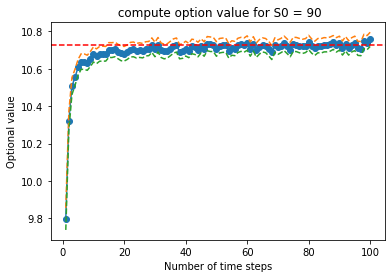

In [117]:
N = np.arange(1,101)

plt.plot(N, X, marker='o', label='Mean')
plt.plot(N, Z, linestyle='dashed', label='Upper Bound')
plt.plot(N, Y, linestyle='dashed', label='Lower Bound')
plt.axhline(y=10.726486710094511, color='red', linestyle='dashed', label='True Value')
plt.title(f' compute option value for S0 = 90')
plt.xlabel('Number of time steps')
plt.ylabel('Optional value')

In [ ]:
from tabulate import tabulate

data = [
    [90,2.7584438561460694 , 2.7356543813655594],
    [100, 7.485087593912603, 7.459916450250769],
    [110, 14.702019669720784
, 14.694633012350002]
]

headers = ["Price","BSM", "LSM"]

table = tabulate(data, headers, tablefmt="pretty")
print(table)

In [105]:
pip install memory_profiler


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: /Users/zhiweilin/opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
